In [115]:
import numpy as np
from scipy.optimize import least_squares
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2

In [177]:
class BundleAdjustment:
    
    def __init__(self, kp_old, kp_new, pose_init):
        self.__kp_old = kp_old
        #self.__kp_factor = kp_factor
        self.__kp_new = kp_new
        self.__pose_init = pose_init
        if not len(kp_old) == len(kp_new):
            print("[EROOR] the number of two sets of points are not equal!")
    
    def angle_to_matrix(self,pose):
        R, _ = cv2.Rodrigues(pose[0:3].astype(np.float32))
        T = pose[3:6].reshape((3,1))
        pose = np.concatenate((R, T), axis=1)
        pose = np.concatenate((pose, np.array([[0,0,0,1]])), axis=0)
        return pose
    
    def error_for_camera_pose(self, pose):
        # it is the reprojection error function for refine only the pose
        # the error = sum of norm2(kp_old - P*kp_new)
        pose = self.angle_to_matrix(pose)
        num_pts = len(self.__kp_old)
        res = 0
        for i in range(num_pts):
            res = res + np.linalg.norm((self.__kp_old[i] - np.dot(pose, self.__kp_new[i])))
        return res
    
    def solve_pose_optimization(self):
        res_1 = least_squares(self.error_for_camera_pose, 
                              self.__pose_init.reshape((-1)),  loss='cauchy', f_scale=0.1)
        self.__pose_res = res_1
        self.__pose = self.angle_to_matrix(self.__pose_res.x)
        return self.__pose
    
    def print_pose_optimization_results(self):
        print(" - the result camera pose is : ", self.__pose_res.x)
        print(" - the result pose matrix is : ")
        print(self.__pose)
        print(" - the cost of optimization is : ", self.__pose_res.cost)
        print(" - the optimality is : ", self.__pose_res.optimality)
    
    def set_factor_for_BA(self, factor):
        if len(factor) == len(self.__kp_old):
            self.__kp_factor = factor
        else:
            print("[ERROR] problem with the size of factor!")
    
    def error_for_points(self,  kp):
        num_pts = len(self.__kp_old)
        res = 0
        kp = kp.reshape(self.__kp_old.shape)
        for i in range(num_pts):
            res = res + np.linalg.norm((kp[i] - np.dot(pose, self.__kp_new[i])))
            res = res + np.linalg.norm((kp[i] - self.__kp_old[i]))*self.__kp_factor[i]
        return res
    
    def solve_points_optimization(self):
        res_1 = least_squares(self.error_for_points, self.__kp_old.reshape((-1)), 
                              loss='cauchy', f_scale=0.1)
        self.__pts_res = res_1
        self.__pts = self.__pts_res.x.reshape(self.__kp_old.shape)
        return self.__pts
    
    def print_point_optimization_results(self):
        print(" - the result points are : ")
        for i in range(len(self.__kp_old)):
            print(self.__pts[i])
        print(" - the cost of optimization is : ", self.__pts_res.cost)
        print(" - the optimality is : ", self.__pts_res.optimality)

# 1. Test
## 1.1 generate data with random errors

In [88]:
def gen_data(kp, pose, noise=0.01, n_outliers=3, random_state=0):
    data = []
    for i in range(len(kp)):
        y = np.dot(np.linalg.inv(pose), kp[i])

        rnd = np.random.RandomState(random_state+i)
        error = noise * rnd.randn(kp[i].size)
        outliers = rnd.randint(0, kp[i].size, n_outliers)
        error[outliers] *= 10
        data.append(y + error)
    return np.asarray(data)

#### init the data with error 0.08 and one outlier

In [170]:
kp_old = np.array([
    [0,0,0,1],[0,1,0,1],[1,0,0,1],[0,0,1,1]
])
pose = np.array([
    [1,0,0,1],[0,1,0,1],[0,0,1,1],[0,0,0,1]
])
kp_new = gen_data(kp_old, pose, 0.08, 1)

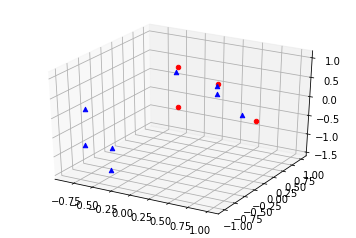

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(kp_old)):
    kp_newn = np.dot(pose, kp_new[i])
    ax.scatter(kp_old[i][0], kp_old[i][1], kp_old[i][2], c='r', marker='o')
    ax.scatter(kp_new[i][0], kp_new[i][1], kp_new[i][2], c='b', marker='^')
    ax.scatter(kp_newn[0], kp_newn[1], kp_newn[2], c='b', marker='^')
plt.show()

## 1.2 Test the camera pose optimization

In [178]:
pose_init = np.array([0,0,0,1,1,1])
ba = BundleAdjustment(kp_old, kp_new, pose_init)
pose = ba.solve_pose_optimization()
ba.print_pose_optimization_results()

 - the result camera pose is :  [ 0.26858654  0.03775524 -0.01099086  1.05303611  0.62464202  1.26505307]
 - the result pose matrix is : 
[[ 0.99923164  0.0158956   0.03582632  1.05303611]
 [-0.00581716  0.96409154 -0.26550642  0.62464202]
 [-0.03876023  0.26509401  0.96344322  1.26505307]
 [ 0.          0.          0.          1.        ]]
 - the cost of optimization is :  0.02607981234201379
 - the optimality is :  0.013103454560647881


## 1.3 Test the points position optimization
I add an factor for the old detected feature points, higher if we had detected it more before (in another word, we are more sure about its position).

In [189]:
factor = np.ones(len(kp_new))*0.6
ba.set_factor_for_BA(factor)
pts = ba.solve_points_optimization()
ba.print_point_optimization_results()

 - the result points are : 
[0.0826282  0.08043925 0.11144703 1.04313611]
[ 0.04152006  0.90659522 -0.19332032  0.9141625 ]
[0.83106416 0.0431134  0.04193197 1.11093013]
[ 0.02973063 -0.09296728  0.94459021  0.8509206 ]
 - the cost of optimization is :  0.023407619764439055
 - the optimality is :  0.003945541121249561


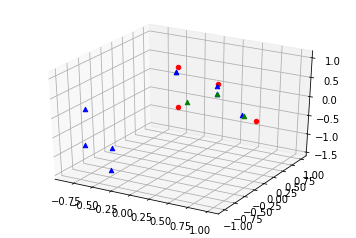

In [190]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(kp_old)):
    kp_newn = np.dot(pose, kp_new[i])
    ax.scatter(kp_old[i][0], kp_old[i][1], kp_old[i][2], c='r', marker='o')
    ax.scatter(kp_new[i][0], kp_new[i][1], kp_new[i][2], c='b', marker='^')
    ax.scatter(pts[i][0], pts[i][1], pts[i][2], c='g', marker='^')
    ax.scatter(kp_newn[0], kp_newn[1], kp_newn[2], c='b', marker='^')
plt.show()

### change factor to 1 or higher

 - the result points are : 
[0. 0. 0. 1.]
[0. 1. 0. 1.]
[1. 0. 0. 1.]
[0. 0. 1. 1.]
 - the cost of optimization is :  0.02607981234201379
 - the optimality is :  0.013395236673140822


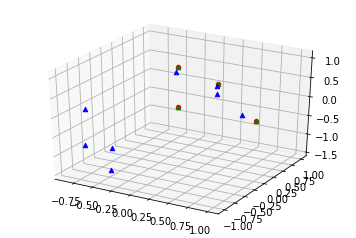

In [191]:
factor = np.ones(len(kp_new))*1
ba.set_factor_for_BA(factor)
pts = ba.solve_points_optimization()
ba.print_point_optimization_results()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(kp_old)):
    kp_newn = np.dot(pose, kp_new[i])
    ax.scatter(kp_old[i][0], kp_old[i][1], kp_old[i][2], c='r', marker='o')
    ax.scatter(kp_new[i][0], kp_new[i][1], kp_new[i][2], c='b', marker='^')
    ax.scatter(pts[i][0], pts[i][1], pts[i][2], c='g', marker='^')
    ax.scatter(kp_newn[0], kp_newn[1], kp_newn[2], c='b', marker='^')
plt.show()